In [23]:
import random
import pandas as pd
import nltk
from nltk.corpus import treebank
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from collections import OrderedDict
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import optim
import numpy as np 
import re
nltk.download('punkt')
nltk.download('treebank')
nltk.download('stopwords')
description_df = pd.read_csv('../dataset/binary_classifiers/description.csv')
installation_df = pd.read_csv('../dataset/binary_classifiers/installation.csv')
invocation_df = pd.read_csv('../dataset/binary_classifiers/invocation.csv')
citation_df = pd.read_csv('../dataset/binary_classifiers/citation.csv')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/charlesxin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     /Users/charlesxin/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charlesxin/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
def lower_stopwords(x):
    x = re.sub(r'[^a-zA-Z\s]', '', x, re.I|re.A)
    x = x.lower()
    x = x.strip()
    text_tokens = [word for word in word_tokenize(x) if word not in stopwords.words()]
    return " ".join(text_tokens)

In [25]:
neg_quant = int(len(invocation_df) * .375)
treebank_background = pd.DataFrame(list(map(lambda sent: ' '.join(sent), random.sample(list(treebank.sents()), neg_quant))), columns=["excerpt"]).assign(invocation=False)
# installation_corpus = pd.concat([installation_df.assign(installation=True), description_df.sample(neg_quant,replace = True).assign(installation=False), invocation_df.sample(neg_quant,replace = True).assign(installation=False), citation_df.sample(neg_quant,replace = True).assign(installation=False),treebank_background], sort=False)
invocation_corpus = pd.concat([invocation_df.assign(invocation=True), description_df.sample(neg_quant,replace = True).assign(invocation=False), installation_df.sample(neg_quant,replace = True).assign(invocation=False), citation_df.sample(neg_quant,replace = True).assign(invocation=False),treebank_background], sort=False)
invocation_corpus.drop('URL', 1, inplace=True)
invocation_corpus.dropna(0, inplace=True)
invocation_corpus.reset_index(drop=True, inplace=True)
invocation_corpus["excerpt"] = invocation_corpus["excerpt"].apply(lower_stopwords)

In [26]:
print(invocation_corpus.groupby(by = "invocation").count())

            contributor  excerpt
invocation                      
False              1254     1254
True               1134     1134


In [27]:
X, y = invocation_corpus.excerpt, invocation_corpus.invocation
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

In [29]:
def curtail(array,threshold = 0.0):
    return array * (array>=threshold)

In [32]:
try: 
    from sklearn.externals import joblib
except:
    import joblib
vectorizer = CountVectorizer()
X_vect_train = vectorizer.fit_transform(X_train).toarray()
#joblib.dump(vectorizer, "model/vectorizer.m")
X_vect_test =  vectorizer.transform(X_test).toarray()

y_hot_train = pd.get_dummies(y_train.values)
y_hot_test = pd.get_dummies(y_test.values)

class FFN(nn.Module):
    
    def __init__(self,layer_arch,input_size,output_size,bias = True):
        super(FFN,self).__init__()
        self.layer_arch = layer_arch
        self.input_size = input_size
        self.output_size = output_size
        self.bias = bias
        self.build_model()
        
    def build_model(self):
        model_arch = []
        unit = self.input_size
        for i,num in enumerate(self.layer_arch):
            model_arch.append(("dense_"+str(i), nn.Linear(unit,num,bias = self.bias)))
            model_arch.append(("nonlinear_"+str(i), nn.ReLU()))
            if(i==1):
                model_arch.append(("dropout_"+str(i), nn.Dropout()))
            unit = num
        model_arch.append(("dense_final",nn.Linear(unit,self.output_size,bias=self.bias)))
        model_arch.append(("act_final",nn.Sigmoid()))
        self.model = nn.Sequential(OrderedDict(model_arch))
    def forward(self,inputs):
        return self.model(inputs)

In [33]:
model = FFN([1024,2048,1024,512,256],X_vect_train.shape[1],2)
epoch_num = 30
bs = 300
history = []
train_ds = TensorDataset(torch.tensor(X_vect_train).float(), torch.tensor(y_hot_train.values).float())
train_dl = DataLoader(train_ds, batch_size=bs)
# opt = optim.SGD(model.parameters(),lr = 0.001)
opt = optim.Adam(model.parameters())
Fs = [0]
for i in range(epoch_num):
    for xb,yb in train_dl:
        target = torch.argmax(yb,dim = 1,keepdim=False)
        pred = model(xb)
        loss_fun = nn.CrossEntropyLoss()
        loss = loss_fun(pred,target)
        loss.backward()
        opt.step()
        opt.zero_grad()        
    #### test metrics #####
    test_pred = model(torch.tensor(X_vect_test).float())
    test_pred = torch.argmax(test_pred,dim=1,keepdim=False)
    ground_truth = torch.argmax(torch.tensor(y_hot_test.values).float(),dim=1,keepdim=False)
    tn, fp, fn, tp = confusion_matrix(test_pred,ground_truth).ravel()

    ### precision ###
    precision = (tp/(tp+fp))*100
    ### recall ###
    recall = (tp/(tp+fn))*100
    ### F-measure ###
    F_measure = (2*precision*recall)/(precision+recall)
    ### accuracy ###
    accuracy = (torch.true_divide((torch.sum((test_pred-ground_truth)==0)),test_pred.shape[0]))*100
#     if F_measure > max(Fs):
#         torch.save(model.state_dict(), 'model/description.pt')
#     Fs.append(F_measure)
    print("test accuracy is {}".format(accuracy))
    print("test precision is {}".format(precision))
    print("test recall is {}".format(recall))
    print("test F-measure is {}".format(F_measure))
    print("************************")

    history.append({"accuracy":accuracy,"precision":precision,"recall":recall,"F_measure":F_measure})

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars


test accuracy is 50.586265563964844
test precision is 0.0
test recall is nan
test F-measure is nan
************************
test accuracy is 81.23953247070312
test precision is 68.13559322033899
test recall is 91.78082191780823
test F-measure is 78.21011673151752
************************
test accuracy is 87.1021728515625
test precision is 87.79661016949153
test recall is 86.33333333333333
test F-measure is 87.05882352941177
************************
test accuracy is 87.939697265625
test precision is 90.16949152542372
test recall is 86.08414239482201
test F-measure is 88.0794701986755
************************
test accuracy is 83.7520980834961
test precision is 77.96610169491525
test recall is 87.78625954198473
test F-measure is 82.58527827648115
************************
test accuracy is 87.26968383789062
test precision is 88.47457627118645
test recall is 86.13861386138613
test F-measure is 87.29096989966555
************************
test accuracy is 87.1021728515625
test precision is 89.8

In [34]:
import matplotlib.pyplot as plt

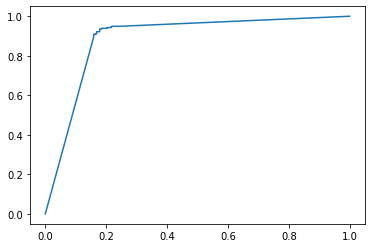

In [35]:
from sklearn import metrics
ground_truth = torch.argmax(torch.tensor(y_hot_test.values).float(),dim=1,keepdim=False)
test_pred_prob = model(torch.tensor(X_vect_test).float())
test_pred = torch.argmax(test_pred_prob,dim=1,keepdim=False)
fpr, tpr, thresholds = metrics.roc_curve(ground_truth.detach().numpy(), test_pred_prob[:,1].detach().numpy())
fig,ax = plt.subplots()
ax.plot(fpr,tpr)
plt.show()

In [36]:
n = len(history)
accu_array = np.array([history[i]["accuracy"] for i in range(n)])
prec_array = np.array([history[i]["precision"] for i in range(n)])
recall_array = np.array([history[i]["recall"] for i in range(n)])
F_array = np.array([history[i]["F_measure"] for i in range(n)])

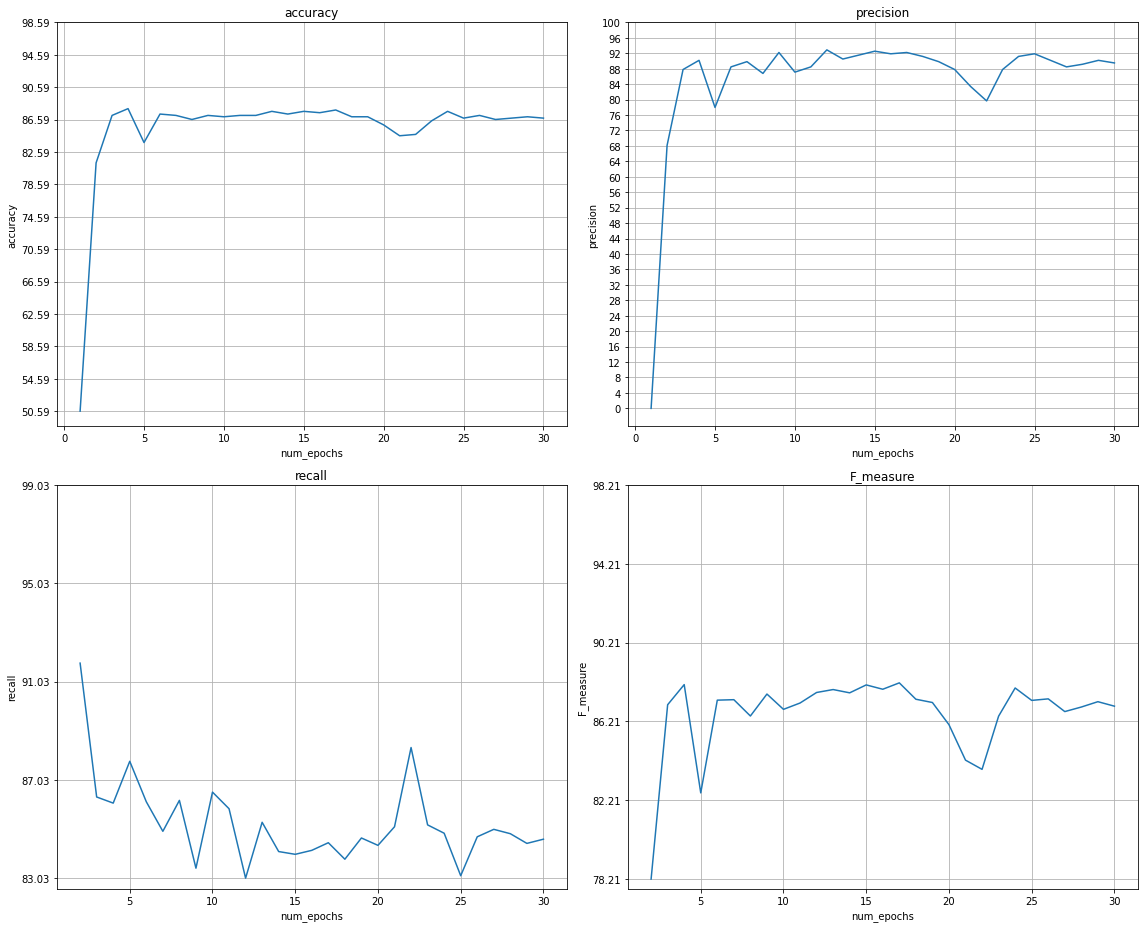

In [37]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16, 13))
interval = 4

ax1.plot([i+1 for i in range(n)],accu_array)
ax1.set_xlabel("num_epochs")
ax1.set_ylabel("accuracy")
ax1.set_title("accuracy")
ax1.grid()
ax1.set_yticks([i for i in np.arange(min(accu_array[~np.isnan(accu_array)]),101,interval)])

ax2.plot([i+1 for i in range(n)],prec_array)
ax2.set_xlabel("num_epochs")
ax2.set_ylabel("precision")
ax2.set_title("precision")
ax2.grid()
ax2.set_yticks([i for i in np.arange(min(prec_array[~np.isnan(prec_array)]),101,interval)])

ax3.plot([i+1 for i in range(n)],recall_array)
ax3.set_xlabel("num_epochs")
ax3.set_ylabel("recall")
ax3.set_title("recall")
ax3.grid()
ax3.set_yticks([i for i in np.arange(min(recall_array[~np.isnan(recall_array)]),101,interval)])

ax4.plot([i+1 for i in range(n)],F_array)
ax4.set_xlabel("num_epochs")
ax4.set_ylabel("F_measure")
ax4.set_title("F_measure")
ax4.grid()
ax4.set_yticks([i for i in np.arange(min(F_array[~np.isnan(F_array)]),101,interval)])
plt.tight_layout()
plt.show()